# SpaceX Launch Data Using MySQL

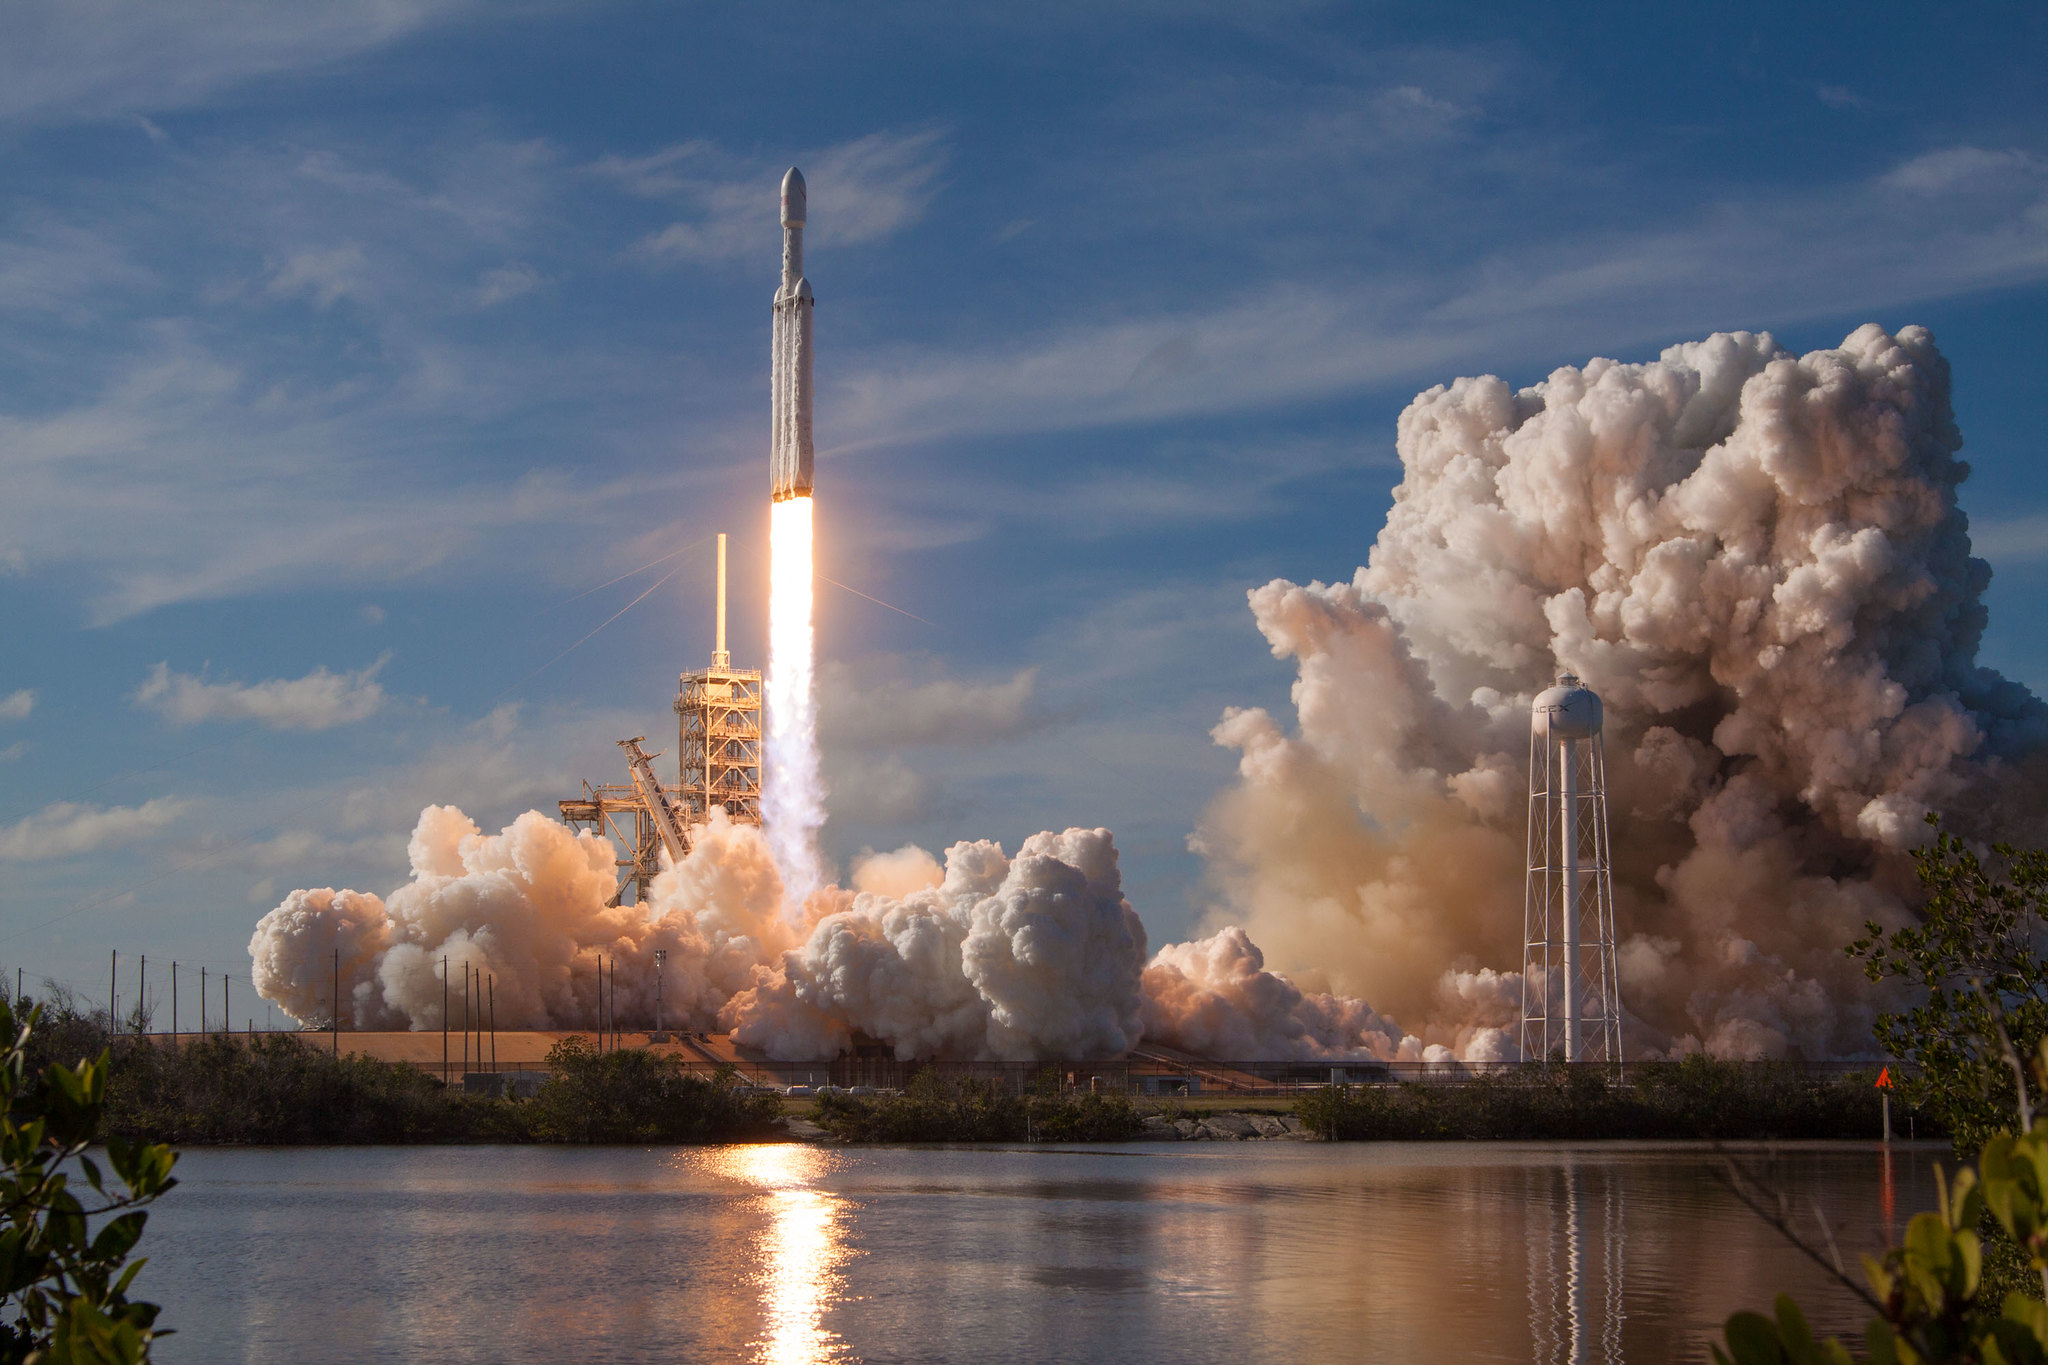

<center>Falcon Heavy Demo Mission, February 6, 2018. Image: SpaceX</center>

## Table of Contents

[1. Create a Connection](#createConnection)

[2. Create a Database](#createDatabase)

[3. Creating Tables](#createTables)

[4. INSERT INTO](#INSERTINTO)

[5. SELECT](#SELECT)

[6. LIMIT](#LIMIT)

[7. WHERE](#WHERE)

[8. GROUP BY](#GROUPBY)

[9. HAVING](#HAVING)

[10. ORDER BY](#ORDERBY)

[11. UPDATE](#UPDATE)

[12. JOIN](#JOIN)

[13. DELETE FROM](#DELETEFROM)

[14. Duplicating Tables](#duplicateTables)

[15. Subquerying](#subquerying)

[16. Importing Data](#importData)

[17. DROP](#DROP)

[18. Close the Connection](#closeConnection)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## SpaceX Launch Data 

The SpaceX launch data used in this tutorial was sourced from Kaggle: https://www.kaggle.com/scoleman/spacex-launch-data. 

It contains mission information for rocket launches conducted by SpaceX between June 2010 to June 2018.

For this MySQL exercise, the original data file was split into three datasets. The first dataset contains the list of launch dates, the second dataset contains each launch's attributes, and the third dataset has each launch's outcome.

In [2]:
# Launch dates dataset
spacex_date_data = pd.read_csv("spacex_launch_data_1.csv")
spacex_date_data.tail()

,Flight Number,Date,Time (UTC)
52,52,2018-04-02,20:30:00
53,53,2018-04-18,22:51:00
54,54,2018-05-11,20:14:00
55,55,2018-05-22,19:47:58
56,56,2018-06-04,4:45:00


In [3]:
# Launch attributes dataset
spacex_attributes_data = pd.read_csv("spacex_launch_data_2.csv")
spacex_attributes_data.head()

,Flight Number,Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer
0,1,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX
1,2,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",NaN,LEO (ISS),NASA (COTS) NRO
2,3,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525,LEO (ISS),NASA (COTS)
3,4,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS)
4,5,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS)


In [4]:
# Launch outcomes dataset
spacex_outcomes_data = pd.read_csv("spacex_launch_data_3.csv")
spacex_outcomes_data.tail()

,Flight Number,Mission Outcome,Landing Outcome
52,52,Success,No attempt
53,53,Success,Success (drone ship)
54,54,Success,Success (drone ship)
55,55,Success,No attempt
56,56,Success,No attempt


Now that we are familiar with the three raw datasets, let's begin using MySQL!

## MySQL

MySQL is an open-source, client-server relational database management system (RDBMS) that is supported by Oracle. A database is an organized collection of data and MySQL is a popular system that can be used to store, manage, and retrieve your data. Since MySQL is a relational database, data is stored into multiple separate storage areas, called tables, rather than in one big storage unit. MySQL also uses a client-server model where the server is used to store the data and the client is used to request the data.

## 1. Create a Connection <a name="createConnection"></a>

To begin, Python needs a MySQL driver to access the MySQL database. We will use the "MySQL Connector" driver. 

It is recommended to use PIP to install "MySQL Connector". In the command line terminal, type:

    pip install mysql-connector-python

Afterwards, you should have successfully downloaded and installed a MySQL driver.

In [5]:
import mysql.connector

If the import is executed without any errors then "MySQL Connector" is installed and ready to be used.

Now, create a connection.

In [6]:
host = "localhost"
user = "root"
password = "..."

mydb = mysql.connector.connect(host=host,
                               user=user,
                               password=password)
print(mydb)

For host, I used local host, and for user, I used root user. The password is whatever you set your MySQL passcode to be. 

## 2. Create a Database <a name="createDatabase"></a>

To create a database in MySQL, use the "CREATE DATABASE" statement.

In [7]:
# Create a new database called, "spacexDB"

mycursor = mydb.cursor()

mycursor.execute("CREATE DATABASE spacexDB")

As you can see from the cell above, we must first create a cursor object to run queries. Cursors are used to scan through the results of a database. The *cursor()* method returns a new cursor object using the connection.

### Check if Database Exists

To check if a database exists, we can list all of the databases in our system by using the "SHOW DATABASES" statement.

In [8]:
mycursor.execute("SHOW DATABASES")

for x in mycursor:
    print(x)

('information_schema',)
('mysql',)
('performance_schema',)
('spacexDB',)
('sys',)


## 3. Creating Tables <a name="createTables"></a>

First access the database you want to create a new table in.

In [9]:
# Accessing the "spacexDB" database

mydb = mysql.connector.connect(host=host,
                               user=user,
                               password=password,
                               database="spacexDB")
print(mydb)

It's not uncommon to clean up or manipulate the raw data before transferring the information to be stored in a database. For example, let's change the data type of some columns in the raw launch date dataset and maybe add a few more columns into it that may be useful to us in the future.

In [10]:
# What are the columns that are currently in the launch date dataset and what data types are they?

spacex_date_data.dtypes

Flight Number    object
Date             object
Time (UTC)       object
dtype: object

In [11]:
# Convert the data in the "Date" and "Time (UTC)" columns from objects to datetimes

import datetime

# Date manipulation
spacex_date_data["Date"]  = pd.to_datetime(spacex_date_data["Date"], format="%Y/%m/%d")
spacex_date_data["year"]  = pd.DatetimeIndex(spacex_date_data["Date"]).year
spacex_date_data["month"] = pd.DatetimeIndex(spacex_date_data["Date"]).month
spacex_date_data["month"] = spacex_date_data["month"].map({1:"JAN", 2:"FEB", 3:"MAR", 4:"APR", 5:"MAY", 6:"JUN", 7:"JUL", 8:"AUG", 9:"SEP", 10:"OCT", 11:"NOV", 12:"DEC"})
spacex_date_data["month_year"] = spacex_date_data["month"].astype(str) + "-" + spacex_date_data["year"].astype(str)

# Time manipulation
spacex_date_data["hour"]  = spacex_date_data["Time (UTC)"].str.split(":").str[0]
spacex_date_data["Time (UTC)"] = pd.to_datetime(spacex_date_data["Time (UTC)"], format="%H:%M:%S")

In [12]:
spacex_date_data.head()

,Flight Number,Date,Time (UTC),year,month,month_year,hour
0,1,2010-06-04,1900-01-01 18:45:00,2010,JUN,JUN-2010,18
1,2,2010-12-08,1900-01-01 15:43:00,2010,DEC,DEC-2010,15
2,3,2012-05-22,1900-01-01 07:44:00,2012,MAY,MAY-2012,7
3,4,2012-10-08,1900-01-01 00:35:00,2012,OCT,OCT-2012,0
4,5,2013-03-01,1900-01-01 15:10:00,2013,MAR,MAR-2013,15


Now that we are happy with how the raw datasets are, we can begin to create the necessary tables to store their information in MySQL.

First, make sure the column and data type parameters in the SQL tables we will create matches the number of columns and datatypes of the raw datasets.

a) Initialize a table for the launch dates.

In [13]:
spacex_date_data.dtypes

Flight Number            object
Date             datetime64[ns]
Time (UTC)       datetime64[ns]
year                      int64
month                    object
month_year               object
hour                     object
dtype: object

In [14]:
# Ex. Create Dates table

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE Dates (Flight_Number VARCHAR(255), \
                                      Date DATE, \
                                      Time_UTC TIME, \
                                      year INT(4), \
                                      month VARCHAR(255), \
                                      month_year VARCHAR(255), \
                                      hour VARCHAR(255))")

b) Initialize a table for the launch attributes.

In [15]:
spacex_attributes_data.dtypes

Flight Number        object
Booster Version      object
Launch Site          object
Payload              object
Payload Mass (kg)    object
Orbit                object
Customer             object
dtype: object

In [16]:
# Ex. Create Attributes table

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE Attributes (Flight_Number VARCHAR(255), \
                                           Booster_Version VARCHAR(255), \
                                           Launch_Site VARCHAR(255), \
                                           Payload VARCHAR(255), \
                                           Payload_Mass_kg VARCHAR(255), \
                                           Orbit VARCHAR(255), \
                                           Customer VARCHAR(255))")

c) Initialize a table for the launch outcomes.

In [17]:
spacex_outcomes_data.dtypes

Flight Number      object
Mission Outcome    object
Landing Outcome    object
dtype: object

In [18]:
# Create Outcomes table

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE Outcomes (Flight_Number VARCHAR(255), \
                                         Mission_Outcome VARCHAR(255), \
                                         Landing_Outcome VARCHAR(255))")

### Check if Tables Exist

To check if a table exists, we can list all of the tables in our database by using the "SHOW TABLES" statement.

In [19]:
mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)

('Attributes',)
('Dates',)
('Outcomes',)


## 4. INSERT INTO <a name="INSERTINTO"></a>

The next step is to fill the empty tables with our data.

### Insert Into Table

To add a row of data into a table in MySQL, use the "INSERT INTO" statement.

In [20]:
# Ex. Insert the first row of data from the launch outcome dataset into the Outcomes table:

sql = "INSERT INTO Outcomes (Flight_Number, Mission_Outcome, Landing_Outcome) VALUES (%s, %s, %s)"
val = ('1', 'Success', 'Failure   (parachute)')
mycursor.execute(sql, val)

mydb.commit()

print(mycursor.rowcount, "record inserted.")

1 record inserted.


### Insert Multiple Rows

To manually insert multiple rows into a table, use the *executemany()* method.

The second parameter of the *executemany()* method is a list of tuples that contain the data you want inserted.

In [21]:
# Ex. Insert the next four rows of data from the launch outcome dataset into the Outcomes table:

ql = "INSERT INTO Outcomes (Flight_Number, Mission_Outcome, Landing_Outcome) VALUES (%s, %s, %s)"
val = [('2', 'Success', 'Failure   (parachute)'),
       ('3', 'Success', 'No attempt'),
       ('4', 'Success', 'No attempt'),
       ('5', 'Success', 'No attempt')]

mycursor.executemany(sql, val)

mydb.commit()

print(mycursor.rowcount, "records were inserted.")

4 records were inserted.


Actually, there is a much faster way of creating a table and then filling it in with its respective data. To do this, use a for loop as shown below.

In [22]:
# a) Insert all data into the Outcomes table:

print('Filling table....')

for i,row in spacex_outcomes_data.iterrows():
    sql = "INSERT INTO spacexDB.Outcomes VALUES (%s,%s,%s)"
    mycursor.execute(sql, tuple(row))
    
    # the connection is not autocommitted by default, so we must commit to save our changes
    mydb.commit()

print("Table filled.")

Filling table....
Table filled.


In [23]:
# b) Insert all data into the Dates table:

print('Filling table....')

for i,row in spacex_date_data.iterrows():
    sql = "INSERT INTO spacexDB.Dates VALUES (%s,%s,%s,%s,%s,%s,%s)"
    mycursor.execute(sql, tuple(row))
    
    # the connection is not autocommitted by default, so we must commit to save our changes
    mydb.commit()

print("Table filled.")

Filling table....
Table filled.


### Handling NaN Values

When inserting data into a table, you may come across an error like: *1054 (42S22): Unknown column 'nan' in 'field list'*

This error is shown because you are trying to send a NaN value to your database. It is not possible to store a NaN value in MySQL.

Only NULL or a value is allowed in MySQL. NULL indicates that there is no value at all and can be used for any kind of data type in a database such as string, integer, date, etc. Note that while NULL can be put into any column type, you cannot put an "empty" value into a non-character field (like integer or float).

There is also a NOT NULL constraint that ensures values stored in a column are not NULL. The syntax for defining a NOT NULL constraint is:

    column_name data_type NOT NULL;
    
If you update or insert NULL into a NOT NULL column, MySQL will issue an error.

You can check for NaN values in your datasets like this:

In [24]:
# 1. Check for NaNs in a dataframe
spacex_attributes_data.isnull().values.any()

True

In [25]:
# 2. Count the NaNs under a single dataframe column

nan = spacex_attributes_data['Flight Number'].isnull().sum()
print("Flight Number: ", nan)

nan = spacex_attributes_data['Booster Version'].isnull().sum()
print("Booster Version: ", nan)

nan = spacex_attributes_data['Launch Site'].isnull().sum()
print("Launch Site: ", nan)

nan = spacex_attributes_data['Payload'].isnull().sum()
print("Payload: ", nan)

nan = spacex_attributes_data['Payload Mass (kg)'].isnull().sum()
print("Payload Mass (kg): ", nan)

nan = spacex_attributes_data['Orbit'].isnull().sum()
print("Orbit: ", nan)

nan = spacex_attributes_data['Customer'].isnull().sum()
print("Customer: ", nan)

Flight Number:  0
Booster Version:  0
Launch Site:  0
Payload:  0
Payload Mass (kg):  2
Orbit:  0
Customer:  0


We see that the "Payload Mass (kg)" column has 2 NaN values. Now, let's convert those NaN's into a *None* value so that we can store them in MySQL.

In [26]:
spacex_attributes_data['Payload Mass (kg)'] = spacex_attributes_data['Payload Mass (kg)'].replace({np.nan: None})

Insert all data into the Attributes table.

In [27]:
# c) Insert all data into the Attributes table:

print('Filling table....')

for i,row in spacex_attributes_data.iterrows():
    sql = "INSERT INTO spacexDB.Attributes VALUES (%s,%s,%s,%s,%s,%s,%s)"
    mycursor.execute(sql, tuple(row))
    
    # the connection is not autocommitted by default, so we must commit to save our changes
    mydb.commit()

print("Table filled.")

Filling table....
Table filled.


## 5. SELECT <a name="SELECT"></a>

Once our tables are filled, we can start reading the data that interests us.

To select from a table in MySQL, use the "SELECT" statement.

In [28]:
# Use the asterisk "*" to retrieve data from all columns of a table:

mycursor.execute("SELECT * FROM Attributes")

# Fetch all the records
myresult = mycursor.fetchall()
for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)')
('6', 'F9 v1.1  B1003', 'VAFB SLC-4E', 'CASSIOPE', '500\xa0', 'Polar LEO', 'MDA')
('7', 'F9 v1.1', 'CCAFS LC-40', 'SES-8', '3,170\xa0', 'GTO', 'SES')
('8', 'F9 v1.1', 'CCAFS LC-40', 'Thaicom 6', '3,325\xa0', 'GTO', 'Thaicom')
('9', 'F9 v1.1', 'CCAFS LC-40', 'SpaceX CRS-3', '2,296\xa0', 'LEO (ISS)', 'NASA (CRS)')
('10', 'F9 v1.1', 'CCAFS LC-40', 'OG2 Mission 1  6 Orbcomm-OG2 satellites', '1,316\xa0', 'LEO', 'Orbcomm')
('11', 'F9 v1.1', 'CCAFS LC-40', 'AsiaSat 8'

Note that the *fetchall()* method is used to fetch all rows from the last executed statement.

### Select Columns

To select a certain column(s) in a table, use the "SELECT" statement followed by the column name(s).

In [29]:
# Ex. Only pull information regarding the launch flight number and booster version:

mycursor.execute("SELECT Flight_Number, Booster_Version FROM Attributes")

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003')
('2', 'F9 v1.0  B0004')
('3', 'F9 v1.0  B0005')
('4', 'F9 v1.0  B0006')
('5', 'F9 v1.0  B0007')
('6', 'F9 v1.1  B1003')
('7', 'F9 v1.1')
('8', 'F9 v1.1')
('9', 'F9 v1.1')
('10', 'F9 v1.1')
('11', 'F9 v1.1')
('12', 'F9 v1.1 B1011')
('13', 'F9 v1.1 B1010')
('14', 'F9 v1.1 B1012')
('15', 'F9 v1.1 B1013')
('16', 'F9 v1.1 B1014')
('17', 'F9 v1.1 B1015')
('18', 'F9 v1.1 B1016')
('19', 'F9 v1.1 B1018')
('20', 'F9 FT B1019')
('21', 'F9 v1.1 B1017')
('22', 'F9 FT B1020')
('23', 'F9 FT B1021.1')
('24', 'F9 FT B1022')
('25', 'F9 FT B1023.1')
('26', 'F9 FT B1024')
('27', 'F9 FT B1025.1')
('28', 'F9 FT B1026')
('29', 'F9 FT B1029.1')
('30', 'F9 FT B1031.1')
('31', 'F9 FT B1030')
('32', 'F9 FT  B1021.2')
('33', 'F9 FT B1032.1')
('34', 'F9 FT B1034')
('35', 'F9 FT B1035.1')
('36', 'F9 FT  B1029.2')
('37', 'F9 FT B1036.1')
('38', 'F9 FT B1037')
('39', 'F9 B4 B1039.1')
('40', 'F9 FT B1038.1')
('41', 'F9 B4 B1040.1')
('42', 'F9 B4 B1041.1')
('43', 'F9 FT  B1031.2')
('44', 'F9 B4 

### SELECT DISTINCT

Use the "DISTINCT" clause in the "SELECT" statement when querying data from a table with duplicate rows. The "DISTINCT" clause will remove those duplicate rows from the query result <u>but</u> not from the table.

In [30]:
# Observe the first ten repeating rows in the Outcomes table.

mycursor.execute("SELECT * FROM Outcomes")

# Fetch all the records
myresult = mycursor.fetchall()
for x in myresult:
    print(x)

('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('6', 'Success', 'Uncontrolled (ocean)')
('7', 'Success', 'No attempt')
('8', 'Success', 'No attempt')
('9', 'Success', 'Controlled (ocean)')
('10', 'Success', 'Controlled (ocean)')
('11', 'Success', 'No attempt')
('12', 'Success', 'No attempt')
('13', 'Success', 'Uncontrolled (ocean)')
('14', 'Success', 'Failure  (drone ship)')
('15', 'Success', 'Controlled (ocean)')
('16', 'Success', 'No attempt')
('17', 'Success', 'Failure  (drone ship)')
('18', 'Success', 'No attempt')
('19', 'Failure  (in flight)', 'Precluded  (drone ship)')
('20', 'Success', 'Success  (ground pad)')
('21', 'Success', 'Failure (drone ship)')
('22', 'Success', 'Failur

In [31]:
# Ex. Only grab the unique rows from Outcomes:

mycursor.execute("SELECT DISTINCT * FROM Outcomes")

# Fetch all the records
myresult = mycursor.fetchall()
for x in myresult:
    print(x)

('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('6', 'Success', 'Uncontrolled (ocean)')
('7', 'Success', 'No attempt')
('8', 'Success', 'No attempt')
('9', 'Success', 'Controlled (ocean)')
('10', 'Success', 'Controlled (ocean)')
('11', 'Success', 'No attempt')
('12', 'Success', 'No attempt')
('13', 'Success', 'Uncontrolled (ocean)')
('14', 'Success', 'Failure  (drone ship)')
('15', 'Success', 'Controlled (ocean)')
('16', 'Success', 'No attempt')
('17', 'Success', 'Failure  (drone ship)')
('18', 'Success', 'No attempt')
('19', 'Failure  (in flight)', 'Precluded  (drone ship)')
('20', 'Success', 'Success  (ground pad)')
('21', 'Success', 'Failure (drone ship)')
('22', 'Success', 'Failure (drone ship)')
('23', 'Success', 'Success  (drone ship)')
('24', 'Success', 'Success (drone ship)')
('25', 'Success', 'Success  (drone ship)')
('26', 'Success', 'Failure  (dro

## 6. LIMIT <a name="LIMIT"></a>

### Limit the Result

To limit the number of records returned from a query, use the "LIMIT" statement.

In [32]:
# Ex. Pull all records from Attributes but limit to only show the first five rows:

mycursor.execute("SELECT * FROM Attributes LIMIT 5")

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)')


### Start From Another Position

If you want to return N records, starting from the Mth record, you can use the "OFFSET" keyword.

In [33]:
# Ex. Start from position 3, and return 5 records:

mycursor.execute("SELECT * FROM Attributes LIMIT 5 OFFSET 2")

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)')
('6', 'F9 v1.1  B1003', 'VAFB SLC-4E', 'CASSIOPE', '500\xa0', 'Polar LEO', 'MDA')
('7', 'F9 v1.1', 'CCAFS LC-40', 'SES-8', '3,170\xa0', 'GTO', 'SES')


## 7. WHERE <a name="WHERE"></a>

When selecting records from a table, you can filter the selection by using the "WHERE" clause.

In [34]:
# Ex. Grab the attributes data associated with flight number 20:

sql = "SELECT * \
       FROM Attributes \
       WHERE Flight_Number = '20'"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('20', 'F9 FT B1019', 'CCAFS LC-40', 'OG2 Mission 2   11 Orbcomm-OG2 satellites', '2,034\xa0', 'LEO', 'Orbcomm')


### IN

Use the "IN" operator to determine if a specified value matches any value in a set of values or a subquery.

In [35]:
# Ex. Grab the attributes data associated with flight numbers 10, 20, 30, 40, and 50:

sql = "SELECT * \
       FROM Attributes \
       WHERE Flight_Number IN (10, 20, 30, 40, 50)"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('10', 'F9 v1.1', 'CCAFS LC-40', 'OG2 Mission 1  6 Orbcomm-OG2 satellites', '1,316\xa0', 'LEO', 'Orbcomm')
('20', 'F9 FT B1019', 'CCAFS LC-40', 'OG2 Mission 2   11 Orbcomm-OG2 satellites', '2,034\xa0', 'LEO', 'Orbcomm')
('30', 'F9 FT B1031.1', 'KSC LC-39A', 'SpaceX CRS-10', '2,490\xa0', 'LEO (ISS)', 'NASA (CRS)')
('40', 'F9 FT B1038.1', 'VAFB SLC-4E', 'Formosat-5', '475\xa0', 'SSO', 'NSPO')
('50', 'F9 B4 B1044', 'CCAFS SLC-40', 'Hispasat 30W-6  PODSat', '6,092\xa0', 'GTO', 'Hispasat  NovaWurks')


### LIKE & Wildcard Characters

Use the "LIKE" logical operator to test whether a string contains a specified pattern or not.

Use the *%* to represent wildcard characters so you can select records that starts, includes, or ends with a given letter or phrase.

In [36]:
# Ex. Grab the attributes data associated with flight numbers that have a 2 somewhere:

sql = "SELECT * \
       FROM Attributes \
       WHERE Flight_Number LIKE '%2%'"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('12', 'F9 v1.1 B1011', 'CCAFS LC-40', 'AsiaSat 6', '4,428\xa0', 'GTO', 'AsiaSat')
('20', 'F9 FT B1019', 'CCAFS LC-40', 'OG2 Mission 2   11 Orbcomm-OG2 satellites', '2,034\xa0', 'LEO', 'Orbcomm')
('21', 'F9 v1.1 B1017', 'VAFB SLC-4E', 'Jason-3', '553\xa0', 'LEO', 'NASA (LSP) NOAA CNES')
('22', 'F9 FT B1020', 'CCAFS LC-40', 'SES-9', '5,271\xa0', 'GTO', 'SES')
('23', 'F9 FT B1021.1', 'CCAFS LC-40', 'SpaceX CRS-8', '3,136\xa0', 'LEO (ISS)', 'NASA (CRS)')
('24', 'F9 FT B1022', 'CCAFS LC-40', 'JCSAT-14', '4,696\xa0', 'GTO', 'SKY Perfect JSAT Group')
('25', 'F9 FT B1023.1', 'CCAFS LC-40', 'Thaicom 8', '3,100\xa0', 'GTO', 'Thaicom')
('26', 'F9 FT B1024', 'CCAFS LC-40', 'ABS-2A Eutelsat 117 West B', '3,600\xa0', 'GTO', 'ABS Eutelsat')
('27', 'F9 FT B1025.1', 'CCAFS LC-40', 'SpaceX CRS-9', '2,257\xa0', 'LEO (ISS)', 'NASA (CRS)')
('28', 'F9 FT B1026', 'CC

### AND

The "AND" operator is a logical operator that combines two or more Boolean expressions and returns true only if both expressions are true. It returns false if at least one of the two expressions is false.

Use the "AND" operator to combine Boolean expressions to filter data.

In [37]:
# Ex. Grab the attributes data associated with NASA as a customer with flight numbers that have a 2 somewhere:

sql = "SELECT * \
       FROM Attributes \
       WHERE Flight_Number LIKE '%2%' AND Customer LIKE '%NASA%'"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('21', 'F9 v1.1 B1017', 'VAFB SLC-4E', 'Jason-3', '553\xa0', 'LEO', 'NASA (LSP) NOAA CNES')
('23', 'F9 FT B1021.1', 'CCAFS LC-40', 'SpaceX CRS-8', '3,136\xa0', 'LEO (ISS)', 'NASA (CRS)')
('27', 'F9 FT B1025.1', 'CCAFS LC-40', 'SpaceX CRS-9', '2,257\xa0', 'LEO (ISS)', 'NASA (CRS)')
('52', 'F9 B4  B1039.2', 'CCAFS SLC-40', 'SpaceX CRS-14', '2,647\xa0', 'LEO (ISS)', 'NASA (CRS)')


### OR

The "OR" operator is a logical operator that combines two Boolean expressions and returns true when either condition is true.

Use the "OR" operator to combine Boolean expressions for filtering data.

In [38]:
# Ex. Grab the attributes data associated with NASA as a customer or that have flight numbers with a 2 somewhere:

sql = "SELECT * \
       FROM Attributes \
       WHERE Flight_Number LIKE '%2%' OR Customer LIKE '%NASA%'"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)')
('9', 'F9 v1.1', 'CCAFS LC-40', 'SpaceX CRS-3', '2,296\xa0', 'LEO (ISS)', 'NASA (CRS)')
('12', 'F9 v1.1 B1011', 'CCAFS LC-40', 'AsiaSat 6', '4,428\xa0', 'GTO', 'AsiaSat')
('13', 'F9 v1.1 B1010', 'CCAFS LC-40', 'SpaceX CRS-4', '2,216\xa0', 'LEO (ISS)', 'NASA (CRS)')
('14', 'F9 v1.1 B1012', 'CCAFS LC-40', 'SpaceX CRS-5', '2,395\xa0', 'LEO (ISS)', 'NASA (CRS)')
('15', 'F9 v1.1 B1013', 'CCAFS LC-40', 'DSCOVR', '570\xa0', 'Sun–Earth L1', 'U.S. Air Force NASA NOAA')
('17', 'F9 v1.1 B1015', 'CCAFS LC-40', 'SpaceX CRS-6', '1,898\xa0', 'LEO (ISS)', 'NASA (CRS)')
('19', 

### BETWEEN

Use the "BETWEEN" logical operator to determine whether a value is in a range of values.

In [39]:
# Ex. Find all launch dates between January 1, 2014 and July 31, 2016:

sql = "SELECT * \
       FROM Dates \
       WHERE Date BETWEEN '2014-01-01' AND '2016-07-31'"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('8', datetime.date(2014, 1, 6), datetime.timedelta(seconds=79560), 2014, 'JAN', 'JAN-2014', '22')
('9', datetime.date(2014, 4, 18), datetime.timedelta(seconds=69900), 2014, 'APR', 'APR-2014', '19')
('10', datetime.date(2014, 7, 14), datetime.timedelta(seconds=54900), 2014, 'JUL', 'JUL-2014', '15')
('11', datetime.date(2014, 8, 5), datetime.timedelta(seconds=28800), 2014, 'AUG', 'AUG-2014', '8')
('12', datetime.date(2014, 9, 7), datetime.timedelta(seconds=18000), 2014, 'SEP', 'SEP-2014', '5')
('13', datetime.date(2014, 9, 21), datetime.timedelta(seconds=21120), 2014, 'SEP', 'SEP-2014', '5')
('14', datetime.date(2015, 1, 10), datetime.timedelta(seconds=35220), 2015, 'JAN', 'JAN-2015', '9')
('15', datetime.date(2015, 2, 11), datetime.timedelta(seconds=82980), 2015, 'FEB', 'FEB-2015', '23')
('16', datetime.date(2015, 3, 2), datetime.timedelta(seconds=13800), 2015, 'MAR', 'MAR-2015', '3')
('17', datetime.date(2015, 4, 14), datetime.timedelta(seconds=72600), 2015, 'APR', 'APR-2015', '20')
(

### NOT BETWEEN

Use the "NOT BETWEEN" logical operator to determine whether a value is outside a range of values.

In [40]:
# Ex. Find all launch dates outside of the January 1, 2014 to July 31, 2016 time period:

sql = "SELECT * \
       FROM Dates \
       WHERE Date NOT BETWEEN '2014-01-01' AND '2015-07-31'"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', datetime.date(2010, 6, 4), datetime.timedelta(seconds=67500), 2010, 'JUN', 'JUN-2010', '18')
('2', datetime.date(2010, 12, 8), datetime.timedelta(seconds=56580), 2010, 'DEC', 'DEC-2010', '15')
('3', datetime.date(2012, 5, 22), datetime.timedelta(seconds=27840), 2012, 'MAY', 'MAY-2012', '7')
('4', datetime.date(2012, 10, 8), datetime.timedelta(seconds=2100), 2012, 'OCT', 'OCT-2012', '0')
('5', datetime.date(2013, 3, 1), datetime.timedelta(seconds=54600), 2013, 'MAR', 'MAR-2013', '15')
('6', datetime.date(2013, 9, 29), datetime.timedelta(seconds=57600), 2013, 'SEP', 'SEP-2013', '16')
('7', datetime.date(2013, 12, 3), datetime.timedelta(seconds=81660), 2013, 'DEC', 'DEC-2013', '22')
('20', datetime.date(2015, 12, 22), datetime.timedelta(seconds=5340), 2015, 'DEC', 'DEC-2015', '1')
('21', datetime.date(2016, 1, 17), datetime.timedelta(seconds=67320), 2016, 'JAN', 'JAN-2016', '18')
('22', datetime.date(2016, 3, 4), datetime.timedelta(seconds=84900), 2016, 'MAR', 'MAR-2016', '23')
('23

## 8. GROUP BY <a name="GROUPBY"></a>

Use the "GROUP BY" clause to group a set of rows by values of columns or expressions.

In [41]:
# Ex. Find the number of Falcon 9 Full Thrust launches from each launch site:

sql = "SELECT Launch_Site, COUNT(*) \
       FROM Attributes \
       WHERE Booster_Version LIKE 'F9 FT%' \
       GROUP BY Launch_Site"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('CCAFS LC-40', 8)
('VAFB SLC-4E', 5)
('KSC LC-39A', 9)
('CCAFS SLC-40', 2)


## 9. HAVING <a name="HAVING"></a>

Use the "HAVING" clause to filter groups based on a specified condition.

In [42]:
# Ex. Find the launch sites that have launched more than five Falcon 9 Full Thrust vehicles:

sql = "SELECT Launch_Site, COUNT(*) AS Count \
       FROM Attributes \
       WHERE Booster_Version LIKE 'F9 FT%' \
       GROUP BY Launch_Site \
       HAVING Count > 5"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('CCAFS LC-40', 8)
('KSC LC-39A', 9)


The HAVING clause is often used with the GROUP BY clause to filter for groups but if the GROUP BY clause is omitted, the HAVING clause acts like the WHERE clause.

In [43]:
# I. Find the payload and payload mass of flight numbers 10, 20, 30, 40, 50:

sql = "SELECT Flight_Number, Payload, Payload_Mass_kg \
       FROM Attributes \
       WHERE Flight_Number IN (10, 20, 30, 40, 50)"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('10', 'OG2 Mission 1  6 Orbcomm-OG2 satellites', '1,316\xa0')
('20', 'OG2 Mission 2   11 Orbcomm-OG2 satellites', '2,034\xa0')
('30', 'SpaceX CRS-10', '2,490\xa0')
('40', 'Formosat-5', '475\xa0')
('50', 'Hispasat 30W-6  PODSat', '6,092\xa0')


In [44]:
# II. Find the payload and payload mass of flight numbers 10, 20, 30, 40, 50:

sql = "SELECT Flight_Number, Payload, Payload_Mass_kg \
       FROM Attributes \
       HAVING Flight_Number IN (10, 20, 30, 40, 50)"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('10', 'OG2 Mission 1  6 Orbcomm-OG2 satellites', '1,316\xa0')
('20', 'OG2 Mission 2   11 Orbcomm-OG2 satellites', '2,034\xa0')
('30', 'SpaceX CRS-10', '2,490\xa0')
('40', 'Formosat-5', '475\xa0')
('50', 'Hispasat 30W-6  PODSat', '6,092\xa0')


As can be seen above, both queries give the exact same results where the GROUP BY clause in the HAVING query is omitted.

## 10. ORDER BY <a name="ORDERBY"></a>

Use the "ORDER BY" statement to sort the result in ascending or descending order.

By default, the "ORDER BY" statement sorts the result in ascending order. To sort the result in descending order, use the "DESC" keyword.

In [45]:
# Ex. Sort the Attributes table in ascending order:

sql = "SELECT * \
       FROM Attributes \
       ORDER BY Flight_Number"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX')
('10', 'F9 v1.1', 'CCAFS LC-40', 'OG2 Mission 1  6 Orbcomm-OG2 satellites', '1,316\xa0', 'LEO', 'Orbcomm')
('11', 'F9 v1.1', 'CCAFS LC-40', 'AsiaSat 8', '4,535\xa0', 'GTO', 'AsiaSat')
('12', 'F9 v1.1 B1011', 'CCAFS LC-40', 'AsiaSat 6', '4,428\xa0', 'GTO', 'AsiaSat')
('13', 'F9 v1.1 B1010', 'CCAFS LC-40', 'SpaceX CRS-4', '2,216\xa0', 'LEO (ISS)', 'NASA (CRS)')
('14', 'F9 v1.1 B1012', 'CCAFS LC-40', 'SpaceX CRS-5', '2,395\xa0', 'LEO (ISS)', 'NASA (CRS)')
('15', 'F9 v1.1 B1013', 'CCAFS LC-40', 'DSCOVR', '570\xa0', 'Sun–Earth L1', 'U.S. Air Force NASA NOAA')
('16', 'F9 v1.1 B1014', 'CCAFS LC-40', 'ABS-3A Eutelsat 115 West B', '4,159\xa0', 'GTO', 'ABS Eutelsat')
('17', 'F9 v1.1 B1015', 'CCAFS LC-40', 'SpaceX CRS-6', '1,898\xa0', 'LEO (ISS)', 'NASA (CRS)')
('18', 'F9 v1.1 B1016', 'CCAFS LC-40', 'TürkmenÄlem 52°E / MonacoSAT', '4,707\xa0', 'GTO', 'Turkmenistan National Space Agency')
('19', '

Notice how the Attribute table is sorted above. Recall that the Flight_Number column, which is the first column in the Attributes table, is not a numeric type column but a varchar type instead. As a result, the ORDER BY statement did not sort the Flight_Number column as ascending numbers.

Now let's try sorting in descending order.

In [46]:
# Ex. Sort the Attributes table in descending order:

sql = "SELECT * \
       FROM Attributes \
       ORDER BY Flight_Number DESC LIMIT 10"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('FH 1', 'B1023.2  (side) , Heavy core B1033, B1025.2 (side) ', 'KSC LC-39A', "Elon Musk's Tesla Roadster", '~1,250\xa0', 'Heliocentric 0.99–1.67 AU  (close to Mars transfer orbit)', 'SpaceX')
('9', 'F9 v1.1', 'CCAFS LC-40', 'SpaceX CRS-3', '2,296\xa0', 'LEO (ISS)', 'NASA (CRS)')
('8', 'F9 v1.1', 'CCAFS LC-40', 'Thaicom 6', '3,325\xa0', 'GTO', 'Thaicom')
('7', 'F9 v1.1', 'CCAFS LC-40', 'SES-8', '3,170\xa0', 'GTO', 'SES')
('6', 'F9 v1.1  B1003', 'VAFB SLC-4E', 'CASSIOPE', '500\xa0', 'Polar LEO', 'MDA')
('56', 'F9 B4  B1040.2', 'CCAFS SLC-40', 'SES-12', '5,384\xa0', 'GTO', 'SES')
('55', 'F9 B4  B1043.2', 'VAFB SLC-4E', 'Iridium NEXT 6   GRACE-FO 1, 2', '6,460\xa0', 'Polar LEO', 'Iridium Communications GFZ • NASA')
('54', 'F9 B5  B1046.1', 'KSC LC-39A', 'Bangabandhu-1', '3,600\xa0', 'GTO', 'Thales-Alenia/BTRC')
('53', 'F9 B4 B1045.1', 'CCAFS SLC-40', 'Transiting Exoplanet Survey Satellite (TESS)', '362\xa0', 'HEO', 'NASA (LSP)')
('52', 'F9 B4  B1039.2', 'CCAFS SLC-40', 'SpaceX CRS-14', '2

## 11. UPDATE <a name="UPDATE"></a>

### Update Table

To update existing records in a table, use the "UPDATE" statement.

In [47]:
# Ex. Change the landing outcome for flight number 56 to "This is updated":

sql = "UPDATE Outcomes \
       SET Landing_Outcome = 'This is updated' \
       WHERE Flight_Number = '56'"

mycursor.execute(sql)

mydb.commit()

print(mycursor.rowcount, "record(s) affected")

1 record(s) affected


The "WHERE" clause specifies which record(s) that should be updated. **If you omit the "WHERE" clause, all records will be updated by what you SET!**

Notice the line: *mydb.commit()* is required to make the changes, otherwise no changes are made to the table.

## 12. JOIN <a name="JOIN"></a>

Very often, we have to work with multiple tables at once. To combine rows from two or more tables based on a related column between them, use a "JOIN" operator.

### Inner Join

The most common type of join is the Inner Join. An inner join matches the results from two tables and only displays the result set that matches the criteria specified in the query. 

In [48]:
# Ex. Merge the Attributes table with the Outcomes table:

sql = "SELECT * \
       FROM Attributes \
       INNER JOIN Outcomes ON Attributes.Flight_Number = Outcomes.Flight_Number"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX', '1', 'Success', 'Failure   (parachute)')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO', '2', 'Success', 'Failure   (parachute)')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)', '3', 'Success', 'No attempt')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)', '4', 'Success', 'No attempt')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)', '5', 'Success', 'No attempt')
('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX', '1', 'Success', 'Failure   (parachute)')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO', '2', 'S

Note that you can use "JOIN" instead of "INNER JOIN". They will both give you the same result.

### Left Join

This join returns all the rows of the table on the left side of (before) the join statement and matches rows for the table on the right side of (after) the join. The rows for which there is not a matching row on the right side will contain null. 

LEFT JOIN is also known as LEFT OUTER JOIN.

In [49]:
# Ex. Merge all rows from the Attributes table with their corresponding Outcomes table data:

sql = "SELECT * \
       FROM Attributes A \
       LEFT JOIN Outcomes O \
       ON A.Flight_Number = O.Flight_Number"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX', '1', 'Success', 'Failure   (parachute)')
('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX', '1', 'Success', 'Failure   (parachute)')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO', '2', 'Success', 'Failure   (parachute)')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO', '2', 'Success', 'Failure   (parachute)')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)', '3', 'Success', 'No attempt')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)', '3', 'Success', 'No attempt')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)',

### Right Join

This join returns all the rows of the table on the right side of (after) the join statement and matches rows for the table on the left side of (before) the join. The rows for which there is no matching row on left side will contain null.

RIGHT JOIN is also known as RIGHT OUTER JOIN.

In [50]:
# Ex. Merge all rows from the Outcomes table with their corresponding Attributes table data:

sql = "SELECT * \
       FROM Attributes A \
       RIGHT JOIN Outcomes O \
       ON A.Flight_Number = O.Flight_Number"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX', '1', 'Success', 'Failure   (parachute)')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO', '2', 'Success', 'Failure   (parachute)')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)', '3', 'Success', 'No attempt')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)', '4', 'Success', 'No attempt')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)', '5', 'Success', 'No attempt')
('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX', '1', 'Success', 'Failure   (parachute)')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO', '2', 'S

### Full Outer Join

The Full Outer Join or Full Join returns <u>all</u> rows from both tables. As such, the full join usually returns a very large result set.

It is important to note that **there is no FULL JOIN on MySQL.** To learn how to simulate a full outer join in MySQL, visit: https://stackoverflow.com/questions/4796872/how-to-do-a-full-outer-join-in-mysql.

## 13. DELETE FROM <a name="DELETEFROM"></a>

Sometimes we may need to delete data from a table.

Let's begin this section by reviewing the Outcomes table.

In [51]:
# Review the Outcomes table

sql = "SELECT * FROM Outcomes"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('6', 'Success', 'Uncontrolled (ocean)')
('7', 'Success', 'No attempt')
('8', 'Success', 'No attempt')
('9', 'Success', 'Controlled (ocean)')
('10', 'Success', 'Controlled (ocean)')
('11', 'Success', 'No attempt')
('12', 'Success', 'No attempt')
('13', 'Success', 'Uncontrolled (ocean)')
('14', 'Success', 'Failure  (drone ship)')
('15', 'Success', 'Controlled (ocean)')
('16', 'Success', 'No attempt')
('17', 'Success', 'Failure  (drone ship)')
('18', 'Success', 'No attempt')
('19', 'Failure  (in flight)', 'Precluded  (drone ship)')
('20', 'Success', 'Success  (ground pad)')
('21', 'Success', 'Failure (drone ship)')
('22', 'Success', 'Failur

### Delete Record

To delete records from an existing table, use the "DELETE FROM" statement.

In [52]:
# Ex. Although there is no flight number 57 in our records, let's just practice the DELETE FROM statement on a non-existent row:

sql = "DELETE FROM Outcomes \
       WHERE Flight_Number = '57'"

mycursor.execute(sql)

mydb.commit()

print(mycursor.rowcount, "record(s) deleted")

0 record(s) deleted


Since there is no data associated with a flight number 57, we see that 0 records were deleted.

Notice the "WHERE" clause in the "DELETE FROM" syntax. The "WHERE" clause specifies which record(s) that should be deleted. **If you omit the "WHERE" clause, all records from the table will be deleted!**

Also, notice that just like "INSERT INTO", the line *mydb.commit()* is required to make changes to the table. If the line is not included, no changes will be made to the table.

### Delete Duplicate Rows

Recall that we manually inserted several rows into the Outcomes table and then we also fully inserted all of its data. As a result, the Outcomes table has several duplicate rows.

In [53]:
# Review the Outcomes table

sql = "SELECT * FROM Outcomes LIMIT 15"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('6', 'Success', 'Uncontrolled (ocean)')
('7', 'Success', 'No attempt')
('8', 'Success', 'No attempt')
('9', 'Success', 'Controlled (ocean)')
('10', 'Success', 'Controlled (ocean)')


You can manually delete a duplicate row from a table by combining both the "DELETE FROM" and "LIMIT" statements.

In [54]:
# Ex. Delete the first duplicate record of flight number 1 from Outcomes:

sql = "DELETE FROM Outcomes \
       WHERE Flight_Number = 1 LIMIT 1"

mycursor.execute(sql)

mydb.commit()

print(mycursor.rowcount, "record(s) deleted")

1 record(s) deleted


The query above just deleted one of the duplicate rows because of the "LIMIT 1".

In [55]:
sql = "SELECT * FROM Outcomes LIMIT 15"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('1', 'Success', 'Failure   (parachute)')
('2', 'Success', 'Failure   (parachute)')
('3', 'Success', 'No attempt')
('4', 'Success', 'No attempt')
('5', 'Success', 'No attempt')
('6', 'Success', 'Uncontrolled (ocean)')
('7', 'Success', 'No attempt')
('8', 'Success', 'No attempt')
('9', 'Success', 'Controlled (ocean)')
('10', 'Success', 'Controlled (ocean)')
('11', 'Success', 'No attempt')


Now, let's finish removing the remaining duplicate rows.

In [56]:
# Ex. Delete the remaining duplicate records from Outcomes:

sql = "DELETE FROM Outcomes \
       WHERE Flight_Number IN (2,3,4,5) LIMIT 4"

mycursor.execute(sql)

mydb.commit()

print(mycursor.rowcount, "record(s) deleted")

4 record(s) deleted


## 14. Duplicating Tables <a name="duplicateTables"></a>

There may be times when you want to clone an existing table as a new table for their similarities in columns and attributes. One reason may be because you want to perform a test using the duplicate table without affecting the original table.

Follow the example below to learn how to duplicate tables.

In [57]:
# Ex. Duplicate the Attributes table with same index and data:

sql = "CREATE TABLE Attributes2 LIKE Attributes"
mycursor.execute(sql)

sql = "INSERT INTO Attributes2 SELECT * FROM Attributes"
mycursor.execute(sql)

mycursor.execute("SELECT * FROM Attributes2")

# Fetch all the records from Attributes2
myresult = mycursor.fetchall()
for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)')
('6', 'F9 v1.1  B1003', 'VAFB SLC-4E', 'CASSIOPE', '500\xa0', 'Polar LEO', 'MDA')
('7', 'F9 v1.1', 'CCAFS LC-40', 'SES-8', '3,170\xa0', 'GTO', 'SES')
('8', 'F9 v1.1', 'CCAFS LC-40', 'Thaicom 6', '3,325\xa0', 'GTO', 'Thaicom')
('9', 'F9 v1.1', 'CCAFS LC-40', 'SpaceX CRS-3', '2,296\xa0', 'LEO (ISS)', 'NASA (CRS)')
('10', 'F9 v1.1', 'CCAFS LC-40', 'OG2 Mission 1  6 Orbcomm-OG2 satellites', '1,316\xa0', 'LEO', 'Orbcomm')
('11', 'F9 v1.1', 'CCAFS LC-40', 'AsiaSat 8'

## 15. Subquerying <a name="subquerying"></a>

A subquery is a query nested within another query such as "SELECT", "INSERT", "UPDATE", or "DELETE". A subquery can also be nested inside another subquery.

A subquery is called the *inner query* while the query that contains the subquery is called the *outer query*. A subquery must be enclosed in parentheses.

In [58]:
# Ex. Return all dates that are associated with customers from NASA:

sql = "SELECT Date \
       FROM Dates \
       WHERE Flight_Number IN (SELECT Flight_Number \
                               FROM Attributes \
                               WHERE Customer LIKE '%NASA%')"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

(datetime.date(2010, 12, 8),)
(datetime.date(2012, 5, 22),)
(datetime.date(2012, 10, 8),)
(datetime.date(2013, 3, 1),)
(datetime.date(2014, 4, 18),)
(datetime.date(2014, 9, 21),)
(datetime.date(2015, 1, 10),)
(datetime.date(2015, 2, 11),)
(datetime.date(2015, 4, 14),)
(datetime.date(2015, 6, 28),)
(datetime.date(2016, 1, 17),)
(datetime.date(2016, 4, 8),)
(datetime.date(2016, 7, 18),)
(datetime.date(2017, 2, 19),)
(datetime.date(2017, 6, 3),)
(datetime.date(2017, 8, 14),)
(datetime.date(2017, 12, 15),)
(datetime.date(2018, 4, 2),)
(datetime.date(2018, 4, 18),)
(datetime.date(2018, 5, 22),)


## 16. Importing Data <a name="importData"></a>

It's very common practice to pull data from a database into your current Python workspace for data analysis.

In Section 4, we learned how to insert data from Python into MySQL. Now, let's see how to import data from MySQL into Python.

In [59]:
# Ex. We want all of the data from the spacexDB database. 
# Combine the data from all three tables into one pandas dataframe.

spacex_df = pd.read_sql("SELECT * \
                         FROM Dates D \
                         INNER JOIN Attributes A ON D.Flight_Number = A.Flight_Number \
                         INNER JOIN Outcomes O ON A.Flight_Number = O.Flight_Number", mydb)
spacex_df

,Flight_Number,Date,Time_UTC,year,month,month_year,hour,Flight_Number,Booster_Version,Launch_Site,Payload,Payload_Mass_kg,Orbit,Customer,Flight_Number,Mission_Outcome,Landing_Outcome
0,1,2010-06-04,18:45:00,2010,JUN,JUN-2010,18,1,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,None,LEO,SpaceX,1,Success,Failure (parachute)
1,2,2010-12-08,15:43:00,2010,DEC,DEC-2010,15,2,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",None,LEO (ISS),NASA (COTS) NRO,2,Success,Failure (parachute)
2,3,2012-05-22,07:44:00,2012,MAY,MAY-2012,7,3,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525,LEO (ISS),NASA (COTS),3,Success,No attempt
3,4,2012-10-08,00:35:00,2012,OCT,OCT-2012,0,4,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),4,Success,No attempt
4,5,2013-03-01,15:10:00,2013,MAR,MAR-2013,15,5,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),5,Success,No attempt
5,6,2013-09-29,16:00:00,2013,SEP,SEP-2013,16,6,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500,Polar LEO,MDA,6,Success,Uncontrolled (ocean)
6,7,2013-12-03,22:41:00,2013,DEC,DEC-2013,22,7,F9 v1.1,CCAFS LC-40,SES-8,"3,170",GTO,SES,7,Success,No attempt
7,8,2014-01-06,22:06:00,2014,JAN,JAN-2014,22,8,F9 v1.1,CCAFS LC-40,Thaicom 6,"3,325",GTO,Thaicom,8,Success,No attempt
8,9,2014-04-18,19:25:00,2014,APR,APR-2014,19,9,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,"2,296",LEO (ISS),NASA (CRS),9,Success,Controlled (ocean)
9,10,2014-07-14,15:15:00,2014,JUL,JUL-2014,15,10,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,"1,316",LEO,Orbcomm,10,Success,Controlled (ocean)


### Clean the Data

It's not uncommon to have to clean imported data from a database. A lot of times, we may need to change the data types of certain columns, remove errors, etc. after pulling from a database.

In our case, because we already did some data cleaning before we inserted the data into MySQL, we don't really have to do much. However, we can still see from the result above that our dataframe contains two copies of the "Flight_Number" column. Let's get rid of those extra duplicated columns.

In [60]:
# Remove all duplicate columns from the pandas dataframe

spacex_df = spacex_df.loc[:,~spacex_df.columns.duplicated()]
spacex_df

,Flight_Number,Date,Time_UTC,year,month,month_year,hour,Booster_Version,Launch_Site,Payload,Payload_Mass_kg,Orbit,Customer,Mission_Outcome,Landing_Outcome
0,1,2010-06-04,18:45:00,2010,JUN,JUN-2010,18,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,None,LEO,SpaceX,Success,Failure (parachute)
1,2,2010-12-08,15:43:00,2010,DEC,DEC-2010,15,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",None,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2,3,2012-05-22,07:44:00,2012,MAY,MAY-2012,7,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525,LEO (ISS),NASA (COTS),Success,No attempt
3,4,2012-10-08,00:35:00,2012,OCT,OCT-2012,0,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
4,5,2013-03-01,15:10:00,2013,MAR,MAR-2013,15,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
5,6,2013-09-29,16:00:00,2013,SEP,SEP-2013,16,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500,Polar LEO,MDA,Success,Uncontrolled (ocean)
6,7,2013-12-03,22:41:00,2013,DEC,DEC-2013,22,F9 v1.1,CCAFS LC-40,SES-8,"3,170",GTO,SES,Success,No attempt
7,8,2014-01-06,22:06:00,2014,JAN,JAN-2014,22,F9 v1.1,CCAFS LC-40,Thaicom 6,"3,325",GTO,Thaicom,Success,No attempt
8,9,2014-04-18,19:25:00,2014,APR,APR-2014,19,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,"2,296",LEO (ISS),NASA (CRS),Success,Controlled (ocean)
9,10,2014-07-14,15:15:00,2014,JUL,JUL-2014,15,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,"1,316",LEO,Orbcomm,Success,Controlled (ocean)


### Data Information

In [61]:
# Data dimensions
print ("Number of columns :",spacex_df.shape[1])
print ("Number of rows    :",spacex_df.shape[0])

Number of columns : 15
Number of rows    : 57


In [62]:
spacex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 15 columns):
Flight_Number      57 non-null object
Date               57 non-null object
Time_UTC           57 non-null timedelta64[ns]
year               57 non-null int64
month              57 non-null object
month_year         57 non-null object
hour               57 non-null object
Booster_Version    57 non-null object
Launch_Site        57 non-null object
Payload            57 non-null object
Payload_Mass_kg    55 non-null object
Orbit              57 non-null object
Customer           57 non-null object
Mission_Outcome    57 non-null object
Landing_Outcome    57 non-null object
dtypes: int64(1), object(13), timedelta64[ns](1)
memory usage: 6.8+ KB


### Analysis

Just for fun, let's find the total launches done by SpaceX per year!

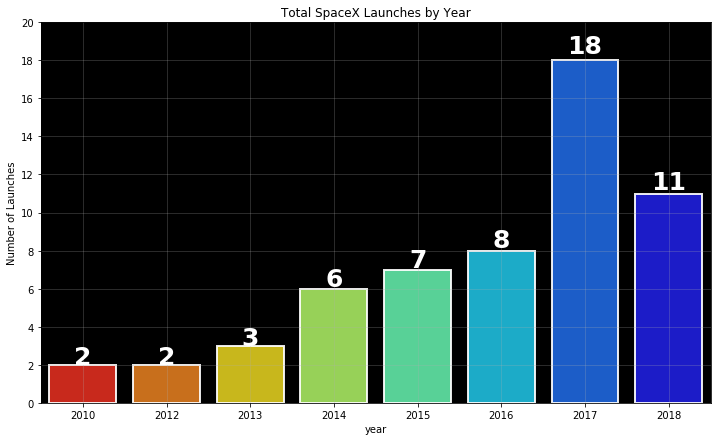

In [63]:
yr = spacex_df.groupby("year")["Flight_Number"].count().reset_index()


plt.figure(figsize=(12,7))
ax = sns.barplot("year","Flight_Number",data=yr,
                 palette="jet_r",linewidth=2,
                 edgecolor=["white"]*len(yr),
                 alpha=.9)
ax.set_facecolor("k")
ax.set_ylabel("Number of Launches")
plt.yticks(np.arange(0,22,2))
plt.title("Total SpaceX Launches by Year")
plt.grid(True,alpha=.3)

# Annotate bars with their respective values
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(int(p.get_height())),
                (x+width/2, y+height*1.02), 
                ha='center',
                color='white', 
                weight='bold', 
                fontsize=25)

plt.show()

The data shows that SpaceX had a maximum of 18 launches in 2017 and there were no launches in 2011.

## 17. DROP <a name="DROP"></a>

Whereas "DELETE" is a Data Manipulation Language (DML) command that is used to remove records from a relation/table, "DROP" is a Data Definition Language (DDL) command that is used to remove elements of a schema like relations/tables, constraints, or entire schemas.

### Drop Column

To drop an existing column in a table, first specify the name of the table that contains the column using "ALTER TABLE" and then use the "DROP COLUMN" statement.

In [64]:
sql = "SELECT * \
       FROM Attributes2 LIMIT 5"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'LEO', 'SpaceX')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'LEO (ISS)', 'NASA (COTS) NRO')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'LEO (ISS)', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'LEO (ISS)', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'LEO (ISS)', 'NASA (CRS)')


In [65]:
# Ex. Drop the "Orbit" column from Attributes2:

sql = "ALTER TABLE Attributes2 \
       DROP COLUMN Orbit"

mycursor.execute(sql)

In [66]:
sql = "SELECT * \
       FROM Attributes2 LIMIT 5"

mycursor.execute(sql)

myresult = mycursor.fetchall()

for x in myresult:
    print(x)

('1', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', None, 'SpaceX')
('2', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats,  barrel of Brouère cheese', None, 'NASA (COTS) NRO')
('3', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2+', '525\xa0', 'NASA (COTS)')
('4', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', '500\xa0', 'NASA (CRS)')
('5', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', '677\xa0', 'NASA (CRS)')


### Drop Table

To drop an existing table, use the "DROP TABLE" statement.

In [67]:
mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)

('Attributes',)
('Attributes2',)
('Dates',)
('Outcomes',)


In [68]:
# Ex. Drop the Attributes2 table:

sql = "DROP TABLE Attributes2"

mycursor.execute(sql)

In [69]:
mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)

('Attributes',)
('Dates',)
('Outcomes',)


### Drop Only if Exist

You can use the "IF EXISTS" keyword to avoid getting an error if the the table you want to drop is already gone, or for any other reason does not exist.

In [70]:
# Ex. Drop the Attributes2 table if it exists in the database:

sql = "DROP TABLE IF EXISTS Attributes2"

myresult = mycursor.execute(sql)

### Drop Database

To drop an entire existing database, use the "DROP DATABASE" statement.

In [71]:
# Ex. Drop the entire spacexDB database:

mycursor.execute("DROP DATABASE spacexDB")

## 18. Close the Connection <a name="closeConnection"></a>

Finally, it's always good practice to close the MySQL connection once you're done using MySQL. This is because if your MySQL server is under heavy usage, there's a chance it will reach it's connection limit and become unresponsive.

In [72]:
if (mydb.is_connected()):
    mycursor.close()
    mydb.close()
    print("MySQL connection is closed.")

MySQL connection is closed.


## References

Basic MySQL Tutorial. (2020, April 11). Retrieved January 31, 2021, from https://www.mysqltutorial.org/basic-mysql-tutorial.aspx.

Christopher, A. (2020, October 11). Importing data from a MySQL database into Pandas data frame. Retrieved January 31, 2021, from https://medium.com/analytics-vidhya/importing-data-from-a-mysql-database-into-pandas-data-frame-a06e392d27d7.

Ganu1899. (2020, October 08). SQL With Python. Retrieved January 31, 2021, from https://www.kaggle.com/ganu1899/sql-with-python.